# PROJECT AI ALGORITMS : BISCUIT MANUFACTURING PROCESS

DIA 4
Martin Laurent Alexandre Laroudie

## PROBLEM DESCRIPTION

Nous sommes dans un problème d'optimisation ayant pour but de maximiser le gain ou le profit d'une usine de biscuit. 

Cette usine fabrique différent biscuits qui ont tous une taille spécifique, une valeur spécifique et surtout un seuil de défault acceptable. C'est à dire que notre patte à biscuit peut contenir des défaults de 3 types (a,b,c) tout au long du rouleau et chaque biscuit peut supporter un certain nombre prédéfini de défault de chaque type pour etre validé.

Voici la liste des biscuit fabriqué dans l'usine :

  - **Biscuit  0** : taille 4, valeur 3 et seuil des defaults { a = 4, b = 2, c = 3}
  - **Biscuit  1** : taille 8, valeur 12 et seuil des defaults { a = 5, b = 4, c = 4}
  - **Biscuit  2** : taille 2, valeur 1 et seuil des defaults { a = 1, b = 2, c = 1}
  - **Biscuit  3** : taille 5, valeur 8 et seuil des defaults { a = 2, b = 3, c = 2} 


Notre usine dispose d'un rouleau de 1 dimension de patte à biscuit de 500 unités. Ce rouleau peut comporter des défaults à des endroits aléatoires que l'on va devoir prendre en compte.



L'objectif de notre projet est de trouver la meilleur solution possible. Une solution est un agencement des biscuits le long du rouleau dans des positions valides. 

Pour etre valide une solution doit repsecter les contraintes suivantes : 

- Les biscuits doivent etre placé à des emplacements entier (1,2,3,... pas de 0.5)
- Des biscuits n'ont pas le droit de se chevaucher
- On ne doit pas dépasser la longueur totale du rouleau
- Pour etre placé à un emplacement le biscuit ne doit pas recouvrir trop de défault par rapport à sa limite
- On peut placer autant de biscuit de chaque type que nécessaire

Pour évaluer une solution on fait la somme des valeurs de tous les biscuits correctement positionnés et on y attribue un score. En revanche pour chaque unité de patte non remplie on pénalise la solution de 1 point pour représenter le manque à gagner pour l'usine.

## FORMULATION IN PYTHON

## IMPLEMENTATION

In [1]:
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

On importe les bibliothèques que l'on va utiliser dans ce projet.
- **pandas** pour gérer notament les défaults
- **typing** pour gagner en clarté dans l'écriture du code
- **pyplot** pour des des visualisation claires et détailées
- **dataclasses** pour créer des classes plus claires et plus faciles que les classes normales. Les constructeurs sont déjà intégrés.

In [2]:
# Définition des classes
@dataclass
class Biscuit:
    id: int
    length: int
    value: int
    max_defects: Dict[str, int]


class DoughRoll:
    def __init__(self, length: int, defects_df: pd.DataFrame):
        self.length = length
        self.defects_df = defects_df 

    def get_defects_in_range(self, start: int, end: int) -> Dict[str, int]:
        # Filter defects within the range [start, end]
        
        range_defects = self.defects_df[(self.defects_df['x'] >= start) & (self.defects_df['x'] < end)]
        
        aggregate_defects = range_defects['class'].value_counts().to_dict()
        
        # Ensure all defect classes are included, even if the count is zero
        for cls in ['a', 'b', 'c']:
            aggregate_defects.setdefault(cls, 0)
        
        return aggregate_defects
    
   

@dataclass
class Solution:
    placements: List[Tuple[int, Biscuit]]  
    total_value: int = 0
    penalties: int = 0

    def calculate_score(self, dough_roll: DoughRoll):
        occupied = [False] * (dough_roll.length )  
        self.total_value = 0
        for position, biscuit in self.placements:
            self.total_value += biscuit.value
            for i in range(position, position + biscuit.length):
                if i < dough_roll.length:
                    occupied[i] = True
        self.penalties = -1 * occupied.count(False)

    def get_score(self):
        return self.total_value + self.penalties


def read_defects(csv_file: str) -> pd.DataFrame:
    defects_df = pd.read_csv(csv_file)
    return defects_df


def initialize_biscuits() -> List[Biscuit]:
    biscuits = [
        Biscuit(id=0, length=4, value=3, max_defects={'a':4, 'b':2, 'c':3}),
        Biscuit(id=1, length=8, value=12, max_defects={'a':5, 'b':4, 'c':4}),
        Biscuit(id=2, length=2, value=1, max_defects={'a':1, 'b':2, 'c':1}),
        Biscuit(id=3, length=5, value=8, max_defects={'a':2, 'b':3, 'c':2}),
    ]
    return biscuits


On va maintenant essayer d'implémenter des algorithmes de résolution pour ce problème. Pour se faire une idée du résultat on va commencer par faire un algorithme greedy pour obtenir une première solution. Cet algorithme prend en compte le ratio valeur/longueur des biscuits pour donner la priorités à certains quand à la solution. Toutefois bien qu'il performe à 675 il est loin d'etre optimal. En faisant comme cela cet lgorithme n'explore pas des solution qui par exemple commence par des débuts moins bons tout en devenant meilleur par la suite. Il ne cherche pas l'optimale mais la première solution complète qui lui est possible de faire. 

### GREEDY SOLUTION

In [3]:
from matplotlib import cm


def greedy_placement(dough_roll: DoughRoll, biscuits: List[Biscuit]) -> Solution:
    placements = []
    position = 0
    occupied = [False] * dough_roll.length  # Pour suivre les positions occupées
    while position < dough_roll.length:
        placed = False
        # Trier les biscuits par ratio valeur/longueur décroissant
        for biscuit in sorted(biscuits, key=lambda b: b.value / b.length, reverse=True):
            if position + biscuit.length > dough_roll.length:
                continue  

            
            defects = dough_roll.get_defects_in_range(position, position + biscuit.length )
            if not all(defects.get(dc, 0) <= biscuit.max_defects.get(dc, 0) for dc in biscuit.max_defects):
                continue  

            # Vérifier les chevauchements
            if any(occupied[i] for i in range(position, position + biscuit.length)):
                continue  

            # Marquer les positions comme occupées
            for i in range(position, position + biscuit.length):
                occupied[i] = True

            # Placer le biscuit
            placements.append((position, biscuit))
            

            
            

        

            position += biscuit.length 
            placed = True
            break
        if not placed:
            position += 1  
    solution = Solution(placements)
    solution.calculate_score(dough_roll)
    return solution


# Fonction pour visualiser la solution
def visualize_solution(dough_roll: DoughRoll, solution: Solution):
    fig, ax = plt.subplots(figsize=(25, 2))
    ax.set_xlim(0, dough_roll.length)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel('Position sur le rouleau de pâte')
    ax.set_title('Placement des Biscuits sur le Rouleau de Pâte')

    for placement in solution.placements:
        pos, biscuit = placement
        rect = plt.Rectangle((pos, 0.25), biscuit.length, 0.5, edgecolor='black', facecolor='skyblue')
        ax.add_patch(rect)
        ax.text(pos + biscuit.length / 2, 0.5, f'{biscuit.id}', ha='center', va='center')

    ax.set_xlim(0, dough_roll.length)
    ax.set_ylim(0, 1)
    plt.show()


def visualize_solution_colored(dough_roll: DoughRoll, solution: Solution):
    fig, ax = plt.subplots(figsize=(25, 2))
    ax.set_xlim(0, dough_roll.length)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel('Position sur le rouleau de pâte')
    ax.set_title('Placement des Biscuits sur le Rouleau de Pâte')

   
    biscuit_ids = [placement[1].id for placement in solution.placements]
    unique_ids = sorted(list(set(biscuit_ids)))
    num_unique = len(unique_ids)

    
    cmap = cm.get_cmap('tab20', num_unique)

    
    id_to_color = {b_id: cmap(i) for i, b_id in enumerate(unique_ids)}

    for placement in solution.placements:
        pos, biscuit = placement
        color = id_to_color[biscuit.id]  
        rect = plt.Rectangle((pos, 0.25), biscuit.length, 0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        ax.text(pos + biscuit.length / 2, 0.5, f'{biscuit.id}', ha='center', va='center', color='black')

    
    patches = [plt.Rectangle((0,0),1,1, facecolor=id_to_color[b_id]) for b_id in unique_ids]
    ax.legend(patches, [f'Biscuit {b_id}' for b_id in unique_ids], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


Mettons en place nos éléments d'initialisoation et commencons le premier algorithme

In [4]:
defects_df = read_defects('defects.csv')
defects_df = defects_df.sort_values(by='x')
defects_df = defects_df.reset_index(drop=True)


dough_roll = DoughRoll(length=500, defects_df=defects_df)
biscuits = initialize_biscuits()
biscuits


[Biscuit(id=0, length=4, value=3, max_defects={'a': 4, 'b': 2, 'c': 3}),
 Biscuit(id=1, length=8, value=12, max_defects={'a': 5, 'b': 4, 'c': 4}),
 Biscuit(id=2, length=2, value=1, max_defects={'a': 1, 'b': 2, 'c': 1}),
 Biscuit(id=3, length=5, value=8, max_defects={'a': 2, 'b': 3, 'c': 2})]

on va creer une carte des défauts pour visuellement mieux se representer à quoi cela ressemble et sur quel zone il faudra etre le plus vigilant pour verifier si nos solutions sont exact.

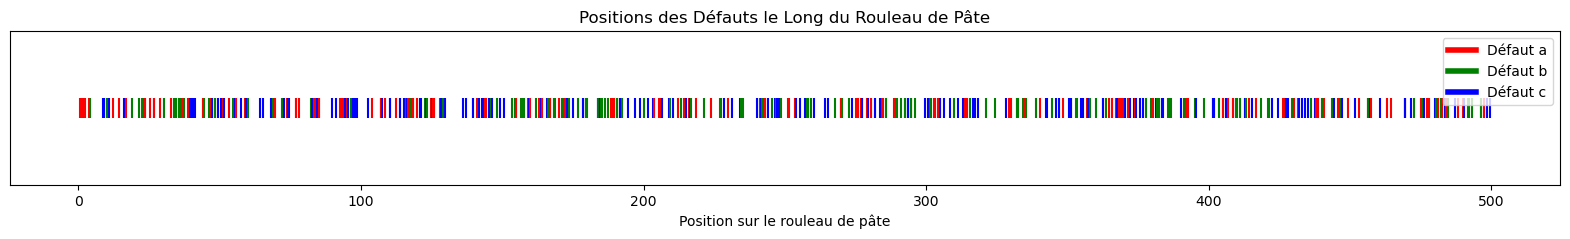

In [16]:
def plot_defects_positions(dough_roll: DoughRoll):
   

    
    defect_colors = {'a': 'red', 'b': 'green', 'c': 'blue'}
    
    
    positions = dough_roll.defects_df['x']
    classes = dough_roll.defects_df['class']
    colors = [defect_colors[cls] for cls in classes]
    
    
    plt.figure(figsize=(20, 2))
    plt.scatter(positions, [1]*len(positions), c=colors, marker='|', s=200)
    plt.yticks([])
    plt.xlabel('Position sur le rouleau de pâte')
    plt.title('Positions des Défauts le Long du Rouleau de Pâte')
    
    
    legend_elements = [
        plt.Line2D([0], [0], color='red', lw=4, label='Défaut a'),
        plt.Line2D([0], [0], color='green', lw=4, label='Défaut b'),
        plt.Line2D([0], [0], color='blue', lw=4, label='Défaut c'),
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.show()

plot_defects_positions(dough_roll)


In [5]:

solution = greedy_placement(dough_roll, biscuits)


solution.calculate_score(dough_roll)
print(f"Valeur Totale des Biscuits Placés: {solution.total_value}")
print(f"Pénalités pour les Positions Non Assignées: {solution.penalties}")
print(f"Score Total de la Solution: {solution.get_score()}")


Valeur Totale des Biscuits Placés: 690
Pénalités pour les Positions Non Assignées: -15
Score Total de la Solution: 675


C:\Users\asus\AppData\Local\Temp\ipykernel_5680\1338639542.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_unique)


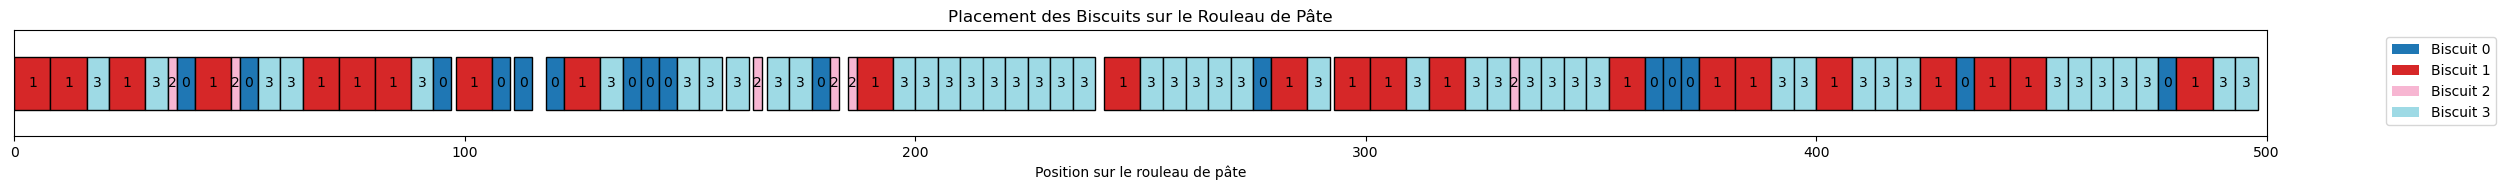

In [9]:
# Visualiser la solution
visualize_solution_colored(dough_roll,solution)



Comme on peut le voir ici, Cet algorithme trouve 15 pénalités ce aaqui est relativement conséquent. toutefois il ne peut pas faire autrement comme il place les biscuits en fonction du ratio il ne modifiera pas la partie qu'il a déjà placé. Cela bloque pour éliminer le plus possible les pénalités. Cela dépend grandement de nos défauts et si c'etait posé en random au lieu de sortir d'un fichier csv on aurait plus des résultats complétement différents.

GA ALGORITHMS

Le deuxième algorithme que nous souhaitions essayer est le genetique. Ce type d'algorithme va s'améliorer au fil des générations afin d'apprendre et d'essayer de trouver un optimum. Il existe de nombreuse méthodes de séléctions voici celles que j'ai séléctionné :
- Tournament selection : On l'a séléctionné car il permet d'assurer un certain elitisme dans la génération suivante tout en ayant un certain niveau d'aléatoire. On séléctionne jusqu'à 5 chromosomes puis on séléctionne ce qui passent à la génération suivante.
- Roulette Wheel : On donne un poids a nos chromosome en fonction de leur fitness ce qui donne plus de chances aux meilleurs d'etre selectionné.
- Rank selection : On fait le rapport de la ftness sur la fitness totale pour trier et classé les solutions. Puis on séléctionne aléatoirement dans ce système trié.

On a également mis en place différent niveau de crossover.
- single point : on divise en 2 les chromosomes parents pour fabriquer les chromosomes fils
- 2 point: On coupe 2 fois les parents on perd en stabilité mais on augmente les variations possibles
- Uniform qui pour chaque nouvel element prend soit du parent 1 ou 2 avec la meme probabilité

On a créée tous ces modèles pour esayer differentes combinaisons et determiner lesquels sont les plus efficaces.

In [10]:
import copy
import random
from typing import List


POPULATION_SIZE = 500
GENERATIONS = 1000
TOURNAMENT_SIZE = 5
MUTATION_RATE = 0.10
ELITE_SIZE_DEFAULT = 5  



def calculate_fitness(chromosome, dough_roll):
    occupied_positions = [False] * dough_roll.length  
    total_value = 0
    penalties = 0
    for position, biscuit in chromosome:
        
        if position + biscuit.length > dough_roll.length:
            return -10000  
        
        overlap = any(occupied_positions[position:position + biscuit.length])
        if overlap:
            return -10000  
        
        defects = dough_roll.get_defects_in_range(position, position + biscuit.length)
        if any(defects.get(dc, 0) > biscuit.max_defects.get(dc, 0) for dc in biscuit.max_defects):
            return -10000  
        
        for i in range(position, position + biscuit.length):
            occupied_positions[i] = True
        total_value += biscuit.value
    
    unassigned_positions = occupied_positions.count(False)
    penalties = -1 * unassigned_positions
    fitness = total_value + penalties
    return fitness

def initialize_population(pop_size, biscuits, dough_roll):
    population = []
    for _ in range(pop_size):
        chromosome = []
        position = 0
        while position < dough_roll.length:
            
            if random.random() < 0.5:
                biscuit = random.choice(biscuits)
                if position + biscuit.length <= dough_roll.length:
                    defects = dough_roll.get_defects_in_range(position, position + biscuit.length)
                    if all(defects.get(dc, 0) <= biscuit.max_defects.get(dc, 0) for dc in biscuit.max_defects):
                        chromosome.append((position, biscuit))
                        position += biscuit.length
                        continue
            position += 1
        population.append(chromosome)
    return population

def tournament_selection(population, fitnesses, tournament_size):
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]  

def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    if total_fitness == 0:
        return random.choice(population)
    pick = random.uniform(0, total_fitness)
    current = 0
    for individual, fitness in zip(population, fitnesses):
        current += fitness
        if current > pick:
            return individual
    return population[-1]

def rank_selection(population, fitnesses):
    sorted_population = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    sorted_fitness = [f for _, f in sorted_population]
    ranks = list(range(1, len(population) + 1))
    total = sum(ranks)
    pick = random.uniform(0, total)
    current = 0
    for (individual, _), rank in zip(sorted_population, ranks):
        current += rank
        if current > pick:
            return individual
    return sorted_population[-1][0]

def crossover(parent1, parent2, dough_roll):
    child_placements = parent1 + parent2
    child_placements = resolve_conflicts(child_placements, dough_roll)
    return child_placements

def single_point_crossover(parent1, parent2, dough_roll):
    if not parent1 or not parent2:
        return copy.deepcopy(parent1) if parent1 else copy.deepcopy(parent2)
    
    point1 = random.randint(1, len(parent1))
    point2 = random.randint(1, len(parent2))
    
    child1 = parent1[:point1] + parent2[point2:]
    child2 = parent2[:point2] + parent1[point1:]
    
    child1 = resolve_conflicts(child1, dough_roll)
    child2 = resolve_conflicts(child2, dough_roll)
    
    return random.choice([child1, child2])

def two_point_crossover(parent1, parent2, dough_roll):
    if not parent1 or not parent2:
        return copy.deepcopy(parent1) if parent1 else copy.deepcopy(parent2)
    
    if len(parent1) < 2 or len(parent2) < 2:
        return single_point_crossover(parent1, parent2, dough_roll)
    
    point1 = random.randint(1, len(parent1) - 1)
    point2 = random.randint(1, len(parent2) - 1)
    
    child1 = parent1[:point1] + parent2[point2:]
    child2 = parent2[:point2] + parent1[point1:]
    
    child1 = resolve_conflicts(child1, dough_roll)
    child2 = resolve_conflicts(child2, dough_roll)
    
    return random.choice([child1, child2])

def uniform_crossover(parent1, parent2, dough_roll, swap_prob=0.5):
    child = []
    max_len = max(len(parent1), len(parent2))
    for i in range(max_len):
        if i < len(parent1) and (i >= len(parent2) or random.random() < swap_prob):
            child.append(parent1[i])
        elif i < len(parent2):
            child.append(parent2[i])
    child = resolve_conflicts(child, dough_roll)
    return child

def resolve_conflicts(placements, dough_roll):
    placements.sort(key=lambda x: x[0])
    occupied = [False] * dough_roll.length  
    valid_placements = []
    for position, biscuit in placements:
        if position + biscuit.length > dough_roll.length:
            continue  
        overlap = any(occupied[position:position + biscuit.length])
        if overlap:
            continue  
        defects = dough_roll.get_defects_in_range(position, position + biscuit.length)
        if any(defects.get(dc, 0) > biscuit.max_defects.get(dc, 0) for dc in biscuit.max_defects):
            continue  
        
        for i in range(position, position + biscuit.length):
            occupied[i] = True
        valid_placements.append((position, biscuit))
    return valid_placements

def mutate(chromosome, biscuits, dough_roll):
    if random.random() < MUTATION_RATE:
        mutation_type = random.choice(['add', 'delete', 'shift'])
        if mutation_type == 'add':
            position = random.randint(0, dough_roll.length - 1)
            biscuit = random.choice(biscuits)
            if position + biscuit.length <= dough_roll.length:
                defects = dough_roll.get_defects_in_range(position, position + biscuit.length)
                if all(defects.get(dc, 0) <= biscuit.max_defects.get(dc, 0) for dc in biscuit.max_defects):
                    overlap = any(
                        (pos <= position < pos + bis.length or
                        position <= pos < position + biscuit.length)
                        for pos, bis in chromosome
                    )
                    if not overlap:
                        chromosome.append((position, biscuit))
        elif mutation_type == 'delete' and len(chromosome) > 0:
            chromosome.pop(random.randint(0, len(chromosome) - 1))
        elif mutation_type == 'shift' and len(chromosome) > 0:
            idx = random.randint(0, len(chromosome) - 1)
            position, biscuit = chromosome[idx]
            new_position = position + random.choice([-1, 1])
            if new_position < 0 or new_position + biscuit.length > dough_roll.length:
                pass  
            else:
                defects = dough_roll.get_defects_in_range(new_position, new_position + biscuit.length)
                if all(defects.get(dc, 0) <= biscuit.max_defects.get(dc, 0) for dc in biscuit.max_defects):
                    overlap = any(
                        (pos <= new_position < pos + bis.length or
                        new_position <= pos < pos + biscuit.length)
                        for i, (pos, bis) in enumerate(chromosome) if i != idx
                    )
                    if not overlap:
                        chromosome[idx] = (new_position, biscuit)
    return chromosome  

def genetic_algorithm(dough_roll, biscuits, selection_method='tournament', crossover_method='standard'):
    population = initialize_population(POPULATION_SIZE, biscuits, dough_roll)
    best_chromosome = None
    best_fitness = float('-inf')
    ELITE_SIZE = 5

    
    if selection_method == 'tournament':
        select = lambda pop, fit: tournament_selection(pop, fit, TOURNAMENT_SIZE)
    elif selection_method == 'roulette':
        select = lambda pop, fit: roulette_wheel_selection(pop, fit)
    elif selection_method == 'rank':
        select = lambda pop, fit: rank_selection(pop, fit)
    else:
        raise ValueError("Méthode de sélection inconnue")

    
    if crossover_method == 'standard':
        crossover_fn = crossover
    elif crossover_method == 'single_point':
        crossover_fn = single_point_crossover
    elif crossover_method == 'two_point':
        crossover_fn = two_point_crossover
    elif crossover_method == 'uniform':
        crossover_fn = uniform_crossover
    else:
        raise ValueError("Méthode de croisement inconnue")

    for generation in range(GENERATIONS):
        fitnesses = [calculate_fitness(chromosome, dough_roll) for chromosome in population]
        
        
        population_with_fitness = list(zip(population, fitnesses))
        population_with_fitness.sort(key=lambda x: x[1], reverse=True)
        
        
        if population_with_fitness[0][1] > best_fitness:
            best_fitness = population_with_fitness[0][1]
            best_chromosome = copy.deepcopy(population_with_fitness[0][0])
        
        new_population = []
        
        
        elites = [copy.deepcopy(individual) for individual, fitness in population_with_fitness[:ELITE_SIZE]]
        new_population.extend(elites)
        
        
        while len(new_population) < POPULATION_SIZE:
            
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            
            child = crossover_fn(parent1, parent2, dough_roll)
            
            child = mutate(child, biscuits, dough_roll)
            
            child_fitness = calculate_fitness(child, dough_roll)
            new_population.append(child)
            
            if child_fitness > best_fitness:
                best_fitness = child_fitness
                best_chromosome = copy.deepcopy(child)
        
        population = new_population
        if (generation + 1) % 100 == 0 or generation == 0:
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")
    
    return best_chromosome, best_fitness


In [ ]:

best_chromosome, best_fitness = genetic_algorithm(
    dough_roll, 
    biscuits, 
    selection_method='roulette', 
    crossover_method='single_point'
)

best_chromosome, best_fitness = genetic_algorithm(
    dough_roll, 
    biscuits, 
    selection_method='rank', 
    crossover_method='uniform'
)

best_chromosome, best_fitness = genetic_algorithm(
    dough_roll, 
    biscuits, 
    selection_method='tournament', 
    crossover_method='standard'
)
best_chromosome, best_fitness = genetic_algorithm(
    dough_roll, 
    biscuits, 
    selection_method='tournament', 
    crossover_method='single_point'
)
best_chromosome, best_fitness = genetic_algorithm(
    dough_roll, 
    biscuits, 
    selection_method='tournament', 
    crossover_method='uniform'
)


Generation 1: Best Fitness = 407


KeyboardInterrupt: 

C:\Users\asus\AppData\Local\Temp\ipykernel_14400\310152896.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_unique)


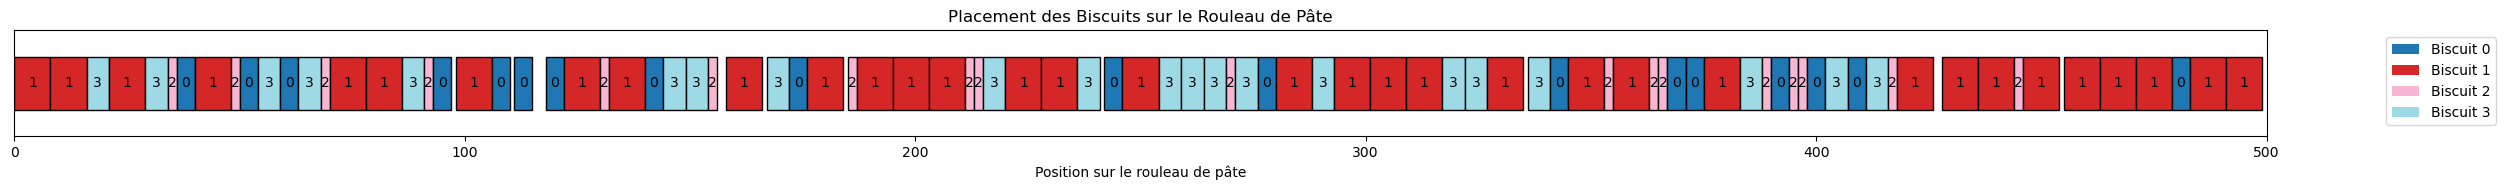

In [ ]:

best_solution = Solution(placements=best_chromosome)
visualize_solution_colored(dough_roll, best_solution)

In [ ]:
best_solution.calculate_score(dough_roll)
print(f"Valeur Totale des Biscuits Placés: {best_solution.total_value}")
print(f"Pénalités pour les Positions Non Assignées: {best_solution.penalties}")
print(f"Score Total de la Solution: {best_solution.get_score()}")

Valeur Totale des Biscuits Placés: 648
Pénalités pour les Positions Non Assignées: -15
Score Total de la Solution: 633


En ayant fait tourner les différents algorithmes avec différentes combinaisons on obtient des résultats relativement similaires. 

On a très vite remarqué que tournament selection etait bien plus efficace que les autres selection methode. Toutefois les crossover méthodes n'ont pas du tout la meme efficacité. Le single point est de loin le meilleur on peut expliquer cela par sa stabilité il arrive sur un grand nombre de générations à un meilleur résultat. Les autres méthodes ont une meilleure convergeance mais pour autant elles ne vont pas aussi prècis avec des scores aussi élevés.

On obtient des score sur 1000 générations entre 640 pour les plus mauvais et 696 pour les meilleurs. On sent que ce n'est pas mal du tout mais on peut faire mieux et surtout les genetic algorithms sont très long en terme de temps d'execution. On doit trouver une solution plus optimale en terme de résultat et de temps d'éxecution.

### CSP SOLUTION

On a choisi de refaire un CSP pour trouver une solution à notre problème mais contrairement au Homework2 on a décidé d'utiliser OrTools de Google. Cette bibliothèqe est interressante car Ortools intègre des système de propagation da contrainte type Ac3 intégré ainsi que des heuristique fort et restricitif comme most constraigning variable, ou choisir des variables qui semblent mener vers la meilleur solution. Cela fait du backtracking avec du pruning avec CP-SAT par exemple mais le plus innovant et performant est le parrallelisme de ortools. Cela veut dire qu'il explore plusieurs chemin simultanément permettant de gagner beaucoup de temps.

Pour notre projet on va chercher à generer tous les placements valides des biscuits qui sont autour de 1400 ensuite on fais un solver qui va cherhcer a partir des placements possibles de determiner une meilleure solution. Quand il est sur une piste qui ne peut plus améliorer l'optimum actuel on passe à la suivante.

In [ ]:



def generate_valid_placements(dough_roll: DoughRoll, biscuits: List[Biscuit]) -> List[Dict]:
    placements = []
    placement_id = 0
    for biscuit in biscuits:
        max_start_pos = dough_roll.length - biscuit.length
        for position in range(0, max_start_pos + 1):
            
            defects = dough_roll.get_defects_in_range(position, position + biscuit.length)
            if all(defects.get(dc, 0) <= biscuit.max_defects[dc] for dc in biscuit.max_defects):
                placements.append({'id': placement_id, 'position': position, 'biscuit': biscuit})
                placement_id += 1
    return placements



valid_placements = generate_valid_placements(dough_roll, biscuits)
print(f"Nombre total de placements valides: {len(valid_placements)}")
from ortools.sat.python import cp_model


model = cp_model.CpModel()


placement_vars = {}
for placement in valid_placements:
    var = model.NewBoolVar(f'place_{placement["id"]}')
    placement_vars[placement['id']] = var


position_to_placements = {}

for placement in valid_placements:
    position = placement['position']
    length = placement['biscuit'].length
    covered_positions = range(position, position + length)
    for pos in covered_positions:
        if pos not in position_to_placements:
            position_to_placements[pos] = []
        position_to_placements[pos].append(placement_vars[placement['id']])


for pos, vars_at_pos in position_to_placements.items():
    model.Add(sum(vars_at_pos) <= 1)


objective_terms = []
for placement in valid_placements:
    var = placement_vars[placement['id']]
    biscuit = placement['biscuit']
    gain = biscuit.value + biscuit.length  
    objective_terms.append(gain * var)

model.Maximize(sum(objective_terms))


Nombre total de placements valides: 1402


In [ ]:

solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print(f"Gain total: {solver.ObjectiveValue() - dough_roll.length}") 
    selected_placements = []
    for placement in valid_placements:
        var = placement_vars[placement['id']]
        if solver.Value(var) == 1:
            selected_placements.append(placement)
else:
    print("Aucune solution trouvée.")


Gain total: 715.0


In [ ]:

solution_placements = []
for placement in selected_placements:
    position = placement['position']
    biscuit = placement['biscuit']
    solution_placements.append((position, biscuit))


solution = Solution(placements=solution_placements)
solution.calculate_score(dough_roll)


print(f"Valeur Totale des Biscuits Placés: {solution.total_value}")
print(f"Pénalités pour les Positions Non Assignées: {solution.penalties}")
print(f"Score Total de la Solution: {solution.get_score()}")


Valeur Totale des Biscuits Placés: 722
Pénalités pour les Positions Non Assignées: -7
Score Total de la Solution: 715


On peut voir que cette solution est la meilleure qu'on a trouvé avec 715 et 7 penalités. On peut pour vérifier son exatitude plot une carte avec les défauts et les solutions Voici un exemple :

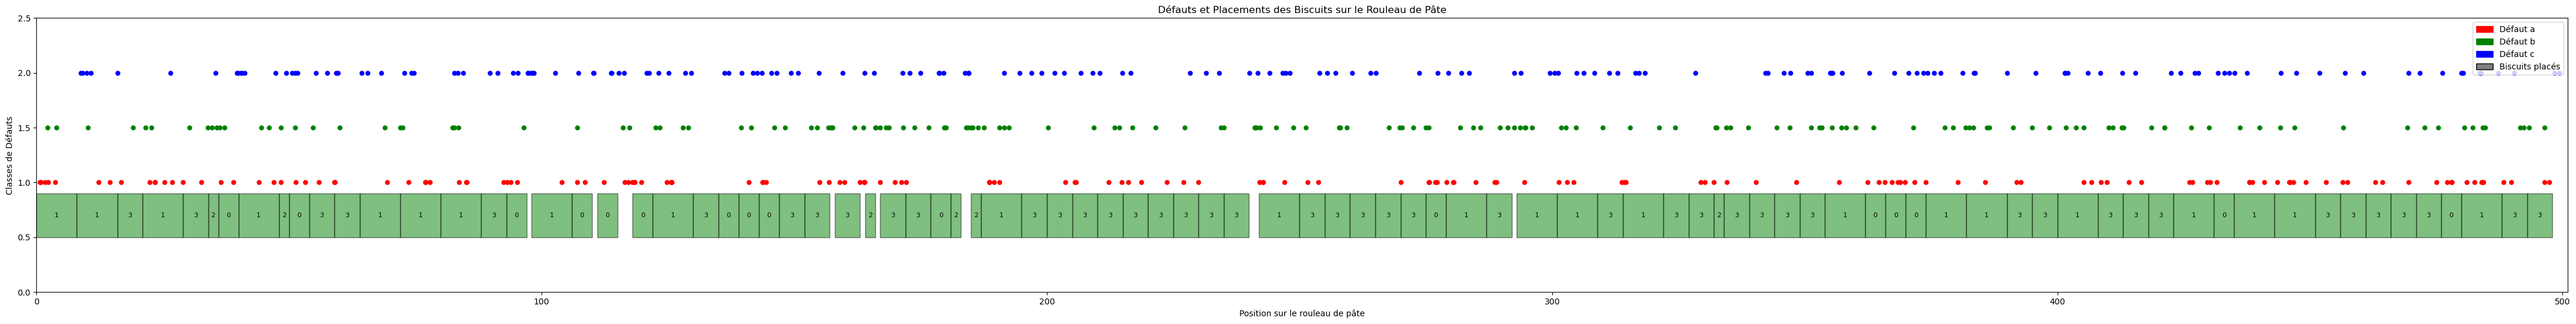

In [ ]:
import matplotlib.patches as patches

def visualize_defects_and_placements(dough_roll: DoughRoll, solution: Solution):
    
    sorted_placements = sorted(solution.placements, key=lambda x: x[0])
    fig, ax = plt.subplots(figsize=(55, 6))
    ax.set_xlim(0, dough_roll.length + 1)
    ax.set_ylim(0, 2.5)  
    ax.set_xlabel('Position sur le rouleau de pâte')
    ax.set_ylabel('Classes de Défauts')
    ax.set_title('Défauts et Placements des Biscuits sur le Rouleau de Pâte')
    
    
    defect_colors = {'a': 'red', 'b': 'green', 'c': 'blue'}
    
   
    for index, row in dough_roll.defects_df.iterrows():
        pos = row['x']
        cls = row['class']
        y = {'a': 1, 'b': 1.5, 'c': 2}[cls]
        ax.plot(pos, y, marker='o', color=defect_colors[cls], markersize=5)
    
   
    for placement in sorted_placements:
        position, biscuit = placement
        start_pos = position
        end_pos = position + biscuit.length - 1
        color = 'green' 
        rect = patches.Rectangle((start_pos, 0.5), biscuit.length, 0.4, linewidth=1, edgecolor='black', facecolor=color, alpha=0.5)
        ax.add_patch(rect)
        ax.text(start_pos + biscuit.length / 2, 0.7, f'{biscuit.id}', ha='center', va='center', fontsize=8, color='black')
    
    
    legend_elements = [
        patches.Patch(facecolor='red', edgecolor='red', label='Défaut a'),
        patches.Patch(facecolor='green', edgecolor='green', label='Défaut b'),
        patches.Patch(facecolor='blue', edgecolor='blue', label='Défaut c'),
        patches.Patch(facecolor='grey', edgecolor='black', label='Biscuits placés')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.show()


visualize_defects_and_placements(dough_roll, solution)


**DYNAMIC PROGRAMMING**

Pour aller plus loin dans ce projet on aimerait develloper une solution que l'on a pas vu dans le cadre de ce cours. On a donc décider de s'orienter vers du dynamic programming. Cela consiste en la subdivision du problème initial en plusieurs nouveaux sous problèmes. La solution optimale globale peut etre construite à partir de plusieurs sous solutions optimales. Cela a plusieurs avantages comme une reduction de la complexité, on simplifie la conception des problèmes,cela garantit l'optimalité de la solution trouvée. Notre problème ressemble à un knapshack (sac à dos) et donc on a pensé à ce modèle qui est plutot bon pour résoudre ce problème.

In [ ]:
def dynamic_programming_solution(dough_roll: DoughRoll, biscuits: List[Biscuit]):
    L = dough_roll.length
    dp = [float('-inf')] * (L + 1)
    dp[L] = 0  

  
    next_pos = [-1] * (L + 1)
    chosen_biscuit = [None] * (L + 1)

    for pos in range(L - 1, -1, -1):
        
        max_gain = dp[pos + 1] - 1  
        next_p = pos + 1
        chosen_b = None

       
        for biscuit in biscuits:
            end_pos = pos + biscuit.length
            if end_pos <= L:
                defects = dough_roll.get_defects_in_range(pos, end_pos)
                if all(defects.get(dc, 0) <= biscuit.max_defects[dc] for dc in biscuit.max_defects):
                    gain = biscuit.value + dp[end_pos]
                    if gain > max_gain:
                        max_gain = gain
                        next_p = end_pos
                        chosen_b = biscuit

        dp[pos] = max_gain
        next_pos[pos] = next_p
        chosen_biscuit[pos] = chosen_b


    pos = 0
    placements = []
    while pos < L:
        if chosen_biscuit[pos]:
            biscuit = chosen_biscuit[pos]
            placements.append((pos, biscuit))
            pos += biscuit.length
        else:
            pos += 1

    solution = Solution(placements)
    solution.calculate_score(dough_roll)
    print(f"Score total de la solution : {solution.get_score()}")
    return solution




Score total de la solution : 715


C:\Users\asus\AppData\Local\Temp\ipykernel_14400\310152896.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_unique)


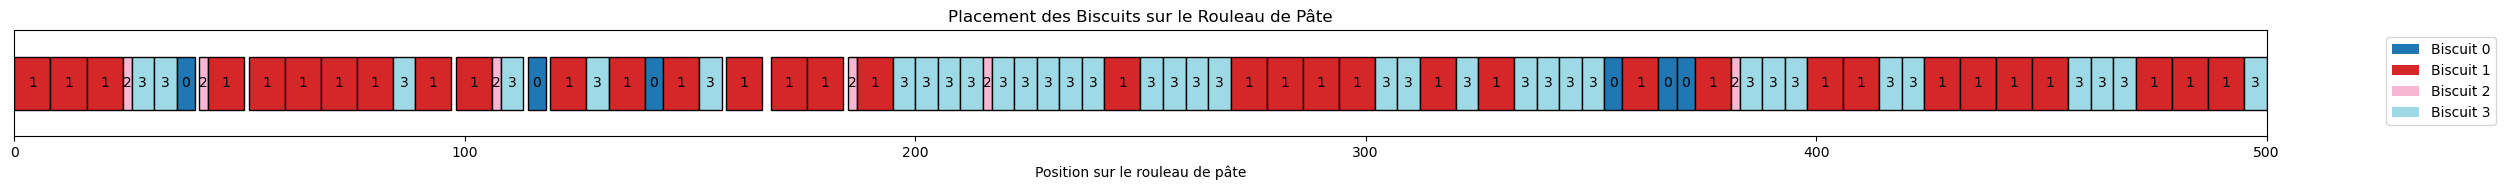

In [ ]:

dp_solution = dynamic_programming_solution(dough_roll, biscuits)
visualize_solution_colored(dough_roll, dp_solution)

On trouve le meme score qu'avec le csp cependant avec la visualisation on voit que cela n'est pas lz meme solution. On en déduit l'exsitence d'ai moins 2 solutions optimales. En reflechissant pourquoi isl ne trouvent pas la meme on a trouvé que le csp parcourt les olutions possiblesdans un certains ordres. Quand on regarde le début de la solution on voit qu'il place au mieux pour augmenter le score mais il est codé de sorte que la solution optiamle gardé en mémoire est la meilleure possible, si 2 sont à égalité il ne conserve que la première. En revanche le dynamic programing sous divise la solution il n'est donc pas biaisé par commencer d'un coté ou un autre et cherhce la solution optimale globale pourchaque sous sytème. Or l'existence de plusieurs solutions egales fait que selon notre découpe des sous système il ne trouve pas en premier la meme que csp.

**CONCLUSION**


Ce projet a exploré plusieurs approches d’optimisation afin de maximiser le profit généré par le placement de biscuits sur un rouleau de pâte présentant différents types de défauts. L’objectif était de positionner les biscuits de manière à respecter les contraintes de taille, de qualité (nombre maximal de défauts admissibles) et d’agencement, tout en maximisant la valeur totale des biscuits placés et en minimisant les pénalités liées aux espaces non occupés.

La première méthode explorée, l’algorithme glouton (greedy), offre l’avantage d’être simple et rapide à implémenter. Cependant, il ne permet d’explorer qu’une petite partie de l’espace de solutions. En conséquence, la solution obtenue est souvent loin d’être optimale, son approche purement locale négligeant de meilleures configurations globales.

Les algorithmes génétiques (GA) ont ensuite été mis en œuvre. Leur capacité à explorer largement l’espace de recherche grâce à la sélection, le croisement et la mutation des solutions permet d’obtenir des résultats plus performants que le simple glouton. Toutefois, malgré leur nature itérative et leur capacité d’amélioration progressive, ils souffrent d’un temps de calcul potentiellement élevé, surtout si l’on souhaite affiner les paramètres ou augmenter la taille de la population pour améliorer le score. De plus, les GA ne garantissent pas toujours l’optimalité de la solution ; ils cherchent un « bon compromis » mais peuvent plafonner dans des optima locaux.

L’utilisation de l’outil OR-Tools (CSP / CP-SAT) de Google a permis d’atteindre un niveau de performance nettement supérieur. Grâce à la propagation de contraintes, aux heuristiques d’exploration avancées, au backtracking intelligent et au parallélisme, le solveur a rapidement trouvé une solution optimale. La contrainte « globale » qu’il impose, associée à la puissance de ses algorithmes internes, offre une efficacité remarquable, réduisant considérablement le temps d’exécution pour des solutions de très haute qualité.

La programmation dynamique (DP), quant à elle, a permis de confirmer l’existence de solutions optimales multiples, offrant un autre regard sur la construction du problème. Bien que plus complexe à formuler, la DP garantit l’optimalité de la solution en résolvant des sous-problèmes plus simples et en combinant leurs résultats. Elle assure une solution optimale similaire à celle du CSP, avec un temps de calcul raisonnable, malgré la complexité du problème.
 

 
 ___
**En termes de performances globales :**

Greedy : Rapide mais non optimal, convient pour une première solution rudimentaire.

GA : Flexible et capable d’améliorations progressives, mais plus lent et sans garantie d’optimalité absolue.

OR-Tools (CSP/CP-SAT) : Très performant, trouve rapidement une solution optimale, excellent compromis entre précision et temps d’exécution.

DP : Garantit l’optimalité, temps de calcul globalement maîtrisé, mais formulation parfois complexe.

En perspective, l’approche pourrait être étendue en intégrant des réseaux de neurones ou des techniques d’apprentissage par renforcement. Ces méthodes « apprendraient » à prédire ou à guider la sélection des placements les plus prometteurs, ce qui pourrait réduire significativement l’espace de recherche. Par ailleurs, elles faciliteraient l’adaptation rapide à d’autres types de problèmes d’optimisation ayant une structure similaire, rendant ainsi la solution plus robuste et plus adaptable.

En conclusion, l’utilisation de techniques avancées comme la programmation par contraintes ou la programmation dynamique garantit l’obtention de solutions optimales. Les méthodes heuristiques (telles que les GA) ou approximatives conservent toutefois leur intérêt pour explorer l’espace de solutions plus librement ou pour fournir des résultats satisfaisants rapidement lorsqu’on ne cherche pas nécessairement l’optimum absolu. L’avenir de tels problèmes d’optimisation pourrait se concentrer sur l’intégration de l’apprentissage automatique, permettant ainsi de combiner le meilleur des deux mondes : la rigueur des méthodes exactes et la flexibilité de l’intelligence artificielle.
